In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import skimage
from skimage import io
from skimage.transform import resize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn

In [2]:
train_dir = os.path.join(sys.path[0], 'train/')
test_dir = os.path.join(sys.path[0], 'test/')

In [3]:
def readHieroglyphData(data_dir):
    images = []
    targets = []
    for hier in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, hier)):
            continue
        for img in os.listdir(os.path.join(data_dir, hier)):
            targets.append(hier)
            images.append(np.asarray(io.imread(os.path.join(data_dir, hier, img))))
    return images, targets

In [4]:
def resizeImageData(data, image_size):
    resize_func = lambda img: resize(img, (image_size, image_size), anti_aliasing=True)
    resized_data = list(map(resize_func, data))
    return resized_data

In [5]:
images_train, targets_train = readHieroglyphData(train_dir)

In [6]:
images_test, targets_test = readHieroglyphData(test_dir)

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(targets_train)
print(list(le.classes_))

['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17', 'G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3', 'R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1', 'X8', 'Y1', 'Y5', 'Z1']


In [8]:
labels_train = le.transform(targets_train)
labels_test = le.transform(targets_test)

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

num_labels = len(le.classes_)
#Images have to have at least 71x71
images_train = np.expand_dims(images_train, -1) 
images_test = np.expand_dims(images_test, -1)

x_train = tf.image.resize_with_pad(
    images_train,
    100,
    100,
    method=tf.image.ResizeMethod.BILINEAR,
    antialias=False)

x_test = tf.image.resize_with_pad(
    images_test,
    100,
    100,
    method=tf.image.ResizeMethod.BILINEAR,
    antialias=False)

y_train = to_categorical(labels_train, num_labels)
y_test = to_categorical(labels_test, num_labels)

x_train.shape

TensorShape([2467, 100, 100, 1])

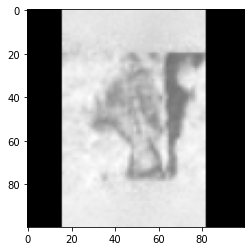

In [10]:
plt.imshow(x_train[0], cmap='gray')

In [11]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models

image_shape = (100, 100, 3)
base_model = Xception(include_top=False, input_shape=image_shape, pooling = 'avg', weights = 'imagenet')

modelXception = models.Sequential()
modelXception.add(base_model)

modelXception.add(layers.Dense(256, activation="relu"))
modelXception.add(layers.Dropout(0.3))
modelXception.add(layers.Dense(128, activation="relu"))
modelXception.add(layers.Dropout(0.3))

modelXception.add(layers.Dense(num_labels, activation = 'softmax'))

In [12]:
modelXception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5160      
Total params: 21,424,080
Trainable params: 21,369,552
Non-trainable params: 54,528
_______________________________________

In [13]:
#https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
train_images_rgb = tf.image.grayscale_to_rgb(x_train)
test_images_rgb = tf.image.grayscale_to_rgb(x_test)

In [14]:
train_images_rgb = tf.keras.applications.xception.preprocess_input(train_images_rgb)
test_images_rgb = tf.keras.applications.xception.preprocess_input(test_images_rgb)

In [15]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

In [16]:
modelXception.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

train_history = modelXception.fit(
    train_images_rgb, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_images_rgb, y_test))

Epoch 1/20
78/78 [==============================] - 32s 327ms/step - loss: 2.2046 - accuracy: 0.4706 - val_loss: 5.0035 - val_accuracy: 0.4866
Epoch 2/20
78/78 [==============================] - 24s 303ms/step - loss: 1.0365 - accuracy: 0.7625 - val_loss: 0.7772 - val_accuracy: 0.8346
Epoch 3/20
78/78 [==============================] - 23s 301ms/step - loss: 0.6462 - accuracy: 0.8476 - val_loss: 0.8343 - val_accuracy: 0.8520
Epoch 4/20
78/78 [==============================] - 23s 300ms/step - loss: 0.4355 - accuracy: 0.8938 - val_loss: 0.7364 - val_accuracy: 0.8425
Epoch 5/20
78/78 [==============================] - 23s 301ms/step - loss: 0.3286 - accuracy: 0.9149 - val_loss: 0.3586 - val_accuracy: 0.9150
Epoch 6/20
78/78 [==============================] - 23s 301ms/step - loss: 0.3325 - accuracy: 0.9193 - val_loss: 7.3603 - val_accuracy: 0.6031
Epoch 7/20
78/78 [==============================] - 23s 301ms/step - loss: 0.2995 - accuracy: 0.9254 - val_loss: 0.2533 - val_accuracy: 0.9370

In [17]:
scores_resnet = modelXception.evaluate(test_images_rgb, y_test)

print("Loss: " + str(scores_resnet[0]))
print("Accuracy: " + str(scores_resnet[1]))

20/20 [==============================] - 1s 65ms/step - loss: 0.1191 - accuracy: 0.9811
Loss: 0.11911115050315857
Accuracy: 0.9811023473739624


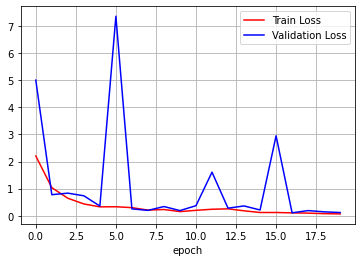

In [18]:
plt.plot(train_history.history['loss'], color='r', label='Train Loss')
plt.plot(train_history.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

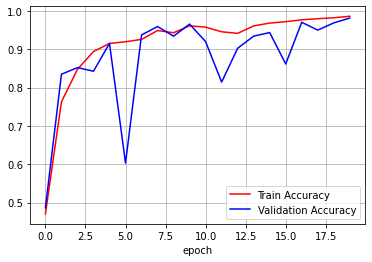

In [19]:
plt.plot(train_history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(train_history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

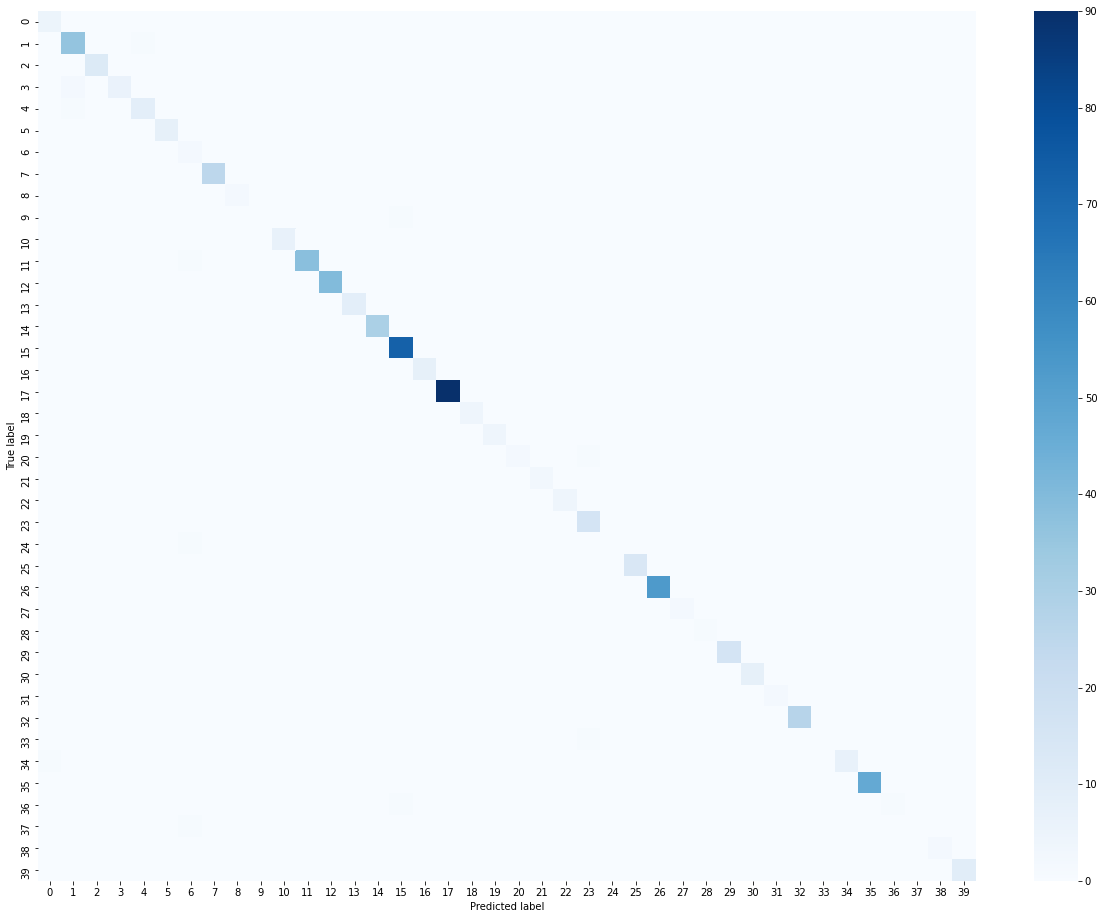

In [20]:
y_pred = [np.argmax(i) for i in modelXception.predict(test_images_rgb)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')